<a href="https://colab.research.google.com/github/Praj-17/Natural-Language-Processing-NLP-/blob/master/spam_email_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intent Classification

We will be using Euron spam dataset for spam email classification problem. The euron datasets ar present at the below location:
http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/index.html
* Readme about the data is also present at the above location which explains details about it.

Generating words that frequently occur in various text database and are necessary part of Natural Language grammer to eliminate them while building features of the words.

In [156]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [157]:
import os
import collections
import nltk
from nltk.classify import NaiveBayesClassifier, accuracy
from nltk.metrics.scores import precision, recall
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import random
from sklearn.utils import shuffle
from nltk.corpus import stopwords
import re


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [158]:

stop_words = set(stopwords.words('english'))

The Euron dataset contains spam (malicious email) and ham (non-malicious email) two folders 
inside the big folder. Each folder spam and ham then again contain many text files. Let's load the data of the files to a list.

In [159]:
def load_files(dir):
    full_data = []
    for file_name in os.listdir(dir):
        with open(dir + '/' + file_name, 'r', encoding='ISO-8859-1') as f:
            full_data.append(f.read())
    return full_data

In [160]:
positive_samples = load_files("/content/drive/MyDrive/data/enron1/ham")
negative_samples = load_files("/content/drive/MyDrive/data/enron1/spam")

In [161]:
positive_samples[:10]

['Subject: hpl noms for february 15 , 2000\n( see attached file : hplo 215 . xls )\n- hplo 215 . xls',
 'Subject: fw : txu lone star pipeline standard pooling agreement\n- - - - - original message - - - - -\nfrom : jeffsmirin @ txu . com [ mailto : jeffsmirin @ txu . com ]\nsent : monday , november 26 , 2001 11 : 31 am\nto : buss , jd\nsubject : txu lone star pipeline standard pooling agreement\nhere is the standard pooling agreement . i noticed that the last two pages\nin the file are actually the cover sheet and index , which should actually\nbe at the front of the document .\n( see attached file : standard pooling agreement . doc )',
 'Subject: enron / hpl actuals for november 13 , 2000\nteco tap 120 . 000 / hpl gas daily\nls hpl lsk ic 30 . 000 / enron',
 'Subject: hpl nom for may 31 2001\n( see attached file : hplno 531 . xls )\n- hplno 531 . xls',
 'Subject: hpl nom for may 30 , 2001\n( see attached file : hplno 530 . xls )\n- hplno 530 . xls',
 'Subject: txu noms . for 10 / 14 -

In [162]:
negative_samples[4:5]

['Subject: hallo mein unbekannter\nhallo\nich danke dir fir deine liebe mail ich habe mich supperdoll\ngefreut : - ) ) ja zu meiner person mvchte ich dir erzdhlen das ich vanessa\nhei _ e . . . und 26 jahre alt bin , ein ziemlich lustiger typ . . . aber leider auch\netwas schichtern . meine hobbys sind mit meinen inlinern durch die botanik zu\nsausen . . . .\ndazu habe ich einen hund und einen hamster . . .\nnaja und sonst mache ich alles was im leben spass macht\nbin da recht spontan . . . ich lege dir hier mal in die mail ein foto\nrein . . vieleicht bin ich ja gar nicht dein typ . . . und schreibe dir dann meine\nganze lebensgeschichte umsonst . . . ldchel . . .\nsollte ich dir aber doch zusagen . . . . . oder . . hm gefallen kannst du mich auf\nmeinem privaten chat erreichen dort\nkannst du sofort mit mir live sprechen . . . dm schreiben . . .\nhttp : / / www . abissno . com\nich wirde mich sehr freuen wieder von\ndir zu hvren . . . . so und nun mache ich erstmal schluss und teste 

In [163]:
# Preprocessing the data includes lemmatization, tokenization and stop word removal
def preprocessing(sentence):
   ######################### Preprocessing for new_data ##########################e
    #line break removal
    sentence = re.sub(r"\r?\\n"," ", sentence)
    #remove special characters
    sentence = re.sub(r'\W+', ' ', sentence)
    #remove numbers
    sentence = sentence.replace('\d+', '')
    sentence = re.sub(r'\b\d+\b', ' ', sentence)
    #remove punctuation
    sentence = sentence.replace('[^\w\s]','')
    #remove underscore
    sentence = sentence.replace('_', '')

    return sentence

def preprocess_sentence(sentence):
    #Delete the term 'subject:'
    sentence =  sentence.replace("Subject:", '').strip()
    sentence = preprocessing(sentence)

    lemmatizer = nltk.WordNetLemmatizer()
    tokens = nltk.word_tokenize(sentence)
    tokens = [w.lower() for w in tokens]
    
    # find least common elements
    word_counts = collections.Counter(tokens)
    uncommon_words = word_counts.most_common()[:-10:-1]
    # filter tokens based on the following
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [w for w in tokens if w not in uncommon_words]
    #lemmatize
    tokens = [lemmatizer.lemmatize(w) for w in tokens] 
    return tokens

In [164]:
# Let us have a look at an email
for email in positive_samples[:1]:
    print(email)

Subject: hpl noms for february 15 , 2000
( see attached file : hplo 215 . xls )
- hplo 215 . xls


In [165]:
# preprocess sentences 
positive_samples = [preprocess_sentence(email) for email in positive_samples]
negative_samples = [preprocess_sentence(email) for email in negative_samples]

In [166]:
# label samples
positive_samples = [(email, 1) for email in positive_samples]
negative_samples = [(email, 0) for email in negative_samples]
all_samples = positive_samples[:1500] + negative_samples
random.shuffle(all_samples)

In [167]:
len(positive_samples)


3692

In [168]:
len(negative_samples)

1500

In [169]:
print(all_samples)

[(['sample', 'road', 'magnet', 'lead', 'turn', 'hour', 'egg', 'cool', 'top', 'minute', 'probable', 'probable', 'drop', 'mine', 'never', 'nothing', 'exercise', 'show', 'find', 'make', 'hold', 'sound', 'hear', 'moon', 'mountain', 'unit', 'change', 'ear', 'silent', 'piece', 'think', 'fire', 'map', 'could', 'new', 'sing', 'year', 'far', 'sun', 'shine', 'major', 'walk', 'felt', 'small', 'sheet', 'two', 'paper', 'trip', 'well', 'country', 'family', 'phone', 'mobile', 'email', 'tithing', 'verizon', 'net'], 0), (['hour', 'contact', 'information', 'lisa', 'maillet', 'contact', 'information', 'would', 'one', 'next', 'day', 'email', 'back', 'correct', 'contact', 'information', 'business', 'hour', 'hour', 'hand', 'preparation', 'gas', 'flow', 'thanks', 'trey', 'lisa', 'maillet', 'work', 'home', 'mobile', 'trey', 'christensen', 'work', 'home', 'pager', 'pin', 'mobile'], 1), (['overseas', 'pharmacy', 'vi', 'want', 'inexpensive', 'pain', 'killer', 'http', 'www', 'ovsr', 'com'], 0), (['best', 'softwar

In [170]:
print(f"{len(all_samples)} emails processed")

3000 emails processed


In [171]:
# Feature extraction
def feature_extraction(tokens):
    # Each word will be a feature and feature value will be word count
    return dict(collections.Counter(tokens))

In [172]:
# features = [(feature_extraction(corpus), label) for corpus, label in all_samples]
features = [(feature_extraction(corpus), label)
              for corpus, label in all_samples]

In [173]:
features[:1]

[({'sample': 1,
   'road': 1,
   'magnet': 1,
   'lead': 1,
   'turn': 1,
   'hour': 1,
   'egg': 1,
   'cool': 1,
   'top': 1,
   'minute': 1,
   'probable': 2,
   'drop': 1,
   'mine': 1,
   'never': 1,
   'nothing': 1,
   'exercise': 1,
   'show': 1,
   'find': 1,
   'make': 1,
   'hold': 1,
   'sound': 1,
   'hear': 1,
   'moon': 1,
   'mountain': 1,
   'unit': 1,
   'change': 1,
   'ear': 1,
   'silent': 1,
   'piece': 1,
   'think': 1,
   'fire': 1,
   'map': 1,
   'could': 1,
   'new': 1,
   'sing': 1,
   'year': 1,
   'far': 1,
   'sun': 1,
   'shine': 1,
   'major': 1,
   'walk': 1,
   'felt': 1,
   'small': 1,
   'sheet': 1,
   'two': 1,
   'paper': 1,
   'trip': 1,
   'well': 1,
   'country': 1,
   'family': 1,
   'phone': 1,
   'mobile': 1,
   'email': 1,
   'tithing': 1,
   'verizon': 1,
   'net': 1},
  0)]

In [174]:
# train test split
def train_test_split(dataset, train_size=0.8):
    num_train_samples = int(len(dataset) * train_size)
    return dataset[:num_train_samples], dataset[num_train_samples:]

In [175]:
training_set, test_set = train_test_split(features, train_size=0.7)

# Model -1 Machine Learning - NaiveBayes Model

In [176]:
model = nltk.classify.NaiveBayesClassifier.train(training_set)
training_error = nltk.classify.accuracy(model, training_set)
print(f'Model training complete. Accuracy on training set: {training_error}')

testing_error = nltk.classify.accuracy(model, test_set)
print(f'Accuracy on test set: {testing_error}')

Model training complete. Accuracy on training set: 0.9880952380952381
Accuracy on test set: 0.9733333333333334


Prediction on Test Dataset

In [177]:
def predict(model, sentence):
  sentence = preprocess_sentence(sentence)
  features = dict([('contains-word(%s)' % w, True) for w in sentence])
  return "HAM" if model.classify(features) else "SPAM"


In [178]:
y_pred = []

for i in test_set:
  y_pred.append(model.classify(i[0]))
  
y_real = [i[1] for i in test_set]
  

### Calculting Metrics

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       492
           1       0.98      0.96      0.97       408

    accuracy                           0.97       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900



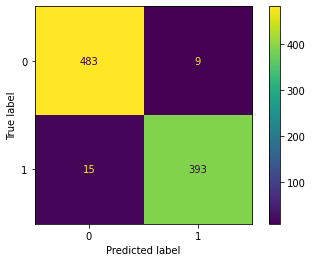

In [179]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
print(classification_report(y_real, y_pred))
dsp = ConfusionMatrixDisplay(confusion_matrix(y_real, y_pred))
dsp.plot()

#  Classifying the Mail Subject

In [180]:
predict(model, 'IMP: Further to Your Application for Virtual Internship and Project at Athlone Institute of Technology, TUS Ireland')

'HAM'

Hence, it is not a SPAM

# Model-2 Deep Learning Model

In [181]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

all_samples

In [182]:
all_samples

[(['sample',
   'road',
   'magnet',
   'lead',
   'turn',
   'hour',
   'egg',
   'cool',
   'top',
   'minute',
   'probable',
   'probable',
   'drop',
   'mine',
   'never',
   'nothing',
   'exercise',
   'show',
   'find',
   'make',
   'hold',
   'sound',
   'hear',
   'moon',
   'mountain',
   'unit',
   'change',
   'ear',
   'silent',
   'piece',
   'think',
   'fire',
   'map',
   'could',
   'new',
   'sing',
   'year',
   'far',
   'sun',
   'shine',
   'major',
   'walk',
   'felt',
   'small',
   'sheet',
   'two',
   'paper',
   'trip',
   'well',
   'country',
   'family',
   'phone',
   'mobile',
   'email',
   'tithing',
   'verizon',
   'net'],
  0),
 (['hour',
   'contact',
   'information',
   'lisa',
   'maillet',
   'contact',
   'information',
   'would',
   'one',
   'next',
   'day',
   'email',
   'back',
   'correct',
   'contact',
   'information',
   'business',
   'hour',
   'hour',
   'hand',
   'preparation',
   'gas',
   'flow',
   'thanks',
   'trey'

In [183]:
texts = []
spams= []
for i in all_samples:
  text = ' '.join(i[0]) 
  texts.append(text)
  spams.append(i[1])

In [184]:
texts[0:1]

['sample road magnet lead turn hour egg cool top minute probable probable drop mine never nothing exercise show find make hold sound hear moon mountain unit change ear silent piece think fire map could new sing year far sun shine major walk felt small sheet two paper trip well country family phone mobile email tithing verizon net']

In [185]:
train_X, test_X, train_Y, test_Y = train_test_split(texts,
                                                    spams,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [186]:
# training the tokenizer
token=Tokenizer()
token.fit_on_texts(train_X)

#Generating token embeddings
Training_seq = token.texts_to_sequences(train_X)
Training_pad = pad_sequences(Training_seq,
							maxlen = 50,
							padding = 'post',
							truncating = 'post')

Testing_seq = token.texts_to_sequences(test_X)
Testing_pad = pad_sequences(Testing_seq,
							maxlen = 50,
							padding = 'post',
							truncating = 'post')


In [187]:
l = []
for i in Training_seq:
  l.append(len(i))
max(l)

2589

In [188]:
# Building the Model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(100000, 32,
									input_length=50))
model.add(tf.keras.layers.LSTM(4))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [189]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
			metrics = ['accuracy'],
			optimizer = 'adam')


In [190]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)


In [191]:
import numpy as np
Training_pad = np.array(Training_pad,dtype='float64')
train_Y = np.array(train_Y, dtype ='float64')
Testing_pad = np.array(Testing_pad, dtype ='float64')
test_Y = np.array(test_Y, dtype ='float64')


In [192]:
Training_pad.shape

(2400, 50)

In [193]:
history = model.fit(Training_pad, train_Y,
					validation_data = (Testing_pad, test_Y),
					epochs = 30,
					verbose = 1,
					batch_size = 32,
					callbacks = [lr, es])


Epoch 1/30


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


75/75 [==============================] - 2s 13ms/step - loss: 0.6765 - accuracy: 0.6271 - val_loss: 0.6358 - val_accuracy: 0.7083 - lr: 0.0010
Epoch 2/30
75/75 [==============================] - 1s 7ms/step - loss: 0.3740 - accuracy: 0.8888 - val_loss: 0.0924 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 3/30
75/75 [==============================] - 1s 7ms/step - loss: 0.0693 - accuracy: 0.9900 - val_loss: 0.0941 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 4/30
75/75 [==============================] - 1s 7ms/step - loss: 0.0451 - accuracy: 0.9933 - val_loss: 0.0693 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 5/30
75/75 [==============================] - 1s 7ms/step - loss: 0.0305 - accuracy: 0.9958 - val_loss: 0.0669 - val_accuracy: 0.9867 - lr: 0.0010


In [194]:

model.evaluate(Testing_pad, test_Y)

19/19 [==============================] - 0s 3ms/step - loss: 0.0924 - accuracy: 0.9933


[0.09243197739124298, 0.9933333396911621]

In [195]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'epoch')

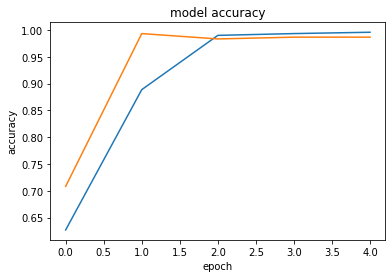

In [196]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [197]:
predict_x=model.predict(Testing_pad) 
# classes_x=np.argmax(predict_x,axis=1)

19/19 [==============================] - 0s 2ms/step


In [198]:
test_Y.shape

(600,)

In [199]:
predicted_values = []
for i in predict_x:
  if i>0.5:
    predicted_values.append(1)
  else:
    predicted_values.append(0)



              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       291
         1.0       1.00      0.99      0.99       309

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



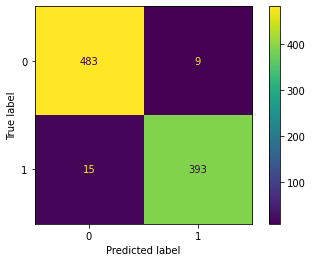

In [200]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
print(classification_report(test_Y, predicted_values))
dsp = ConfusionMatrixDisplay(confusion_matrix(y_real, y_pred))
dsp.plot()